In [4]:
# https://www.yutaka-note.com/entry/matplotlib_inline
%matplotlib inline

In [5]:
import collections
import csv
import datetime
import os
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycircos
from collections import Counter
from IPython.display import display
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle

In [6]:
# define the UP or DOWN regulated genes
direction = "UP"

# define the input file
HUMAN_CHROMOSOME = "../data/chromosome/chromosome_human.tsv"
RICE_CHROMOSOME  = "../data/chromosome/chromosome_rice.tsv"
# combined extarcted gene list by HN-score and chromosome position
HUMAN_POSITION = "../data/human_annotation/human_position_up.tsv"
RICE_POSITION  = "../data/rice_annotation/rice_position_up.tsv"
# GOslim
HUMAN_GOSLIM = "../data/biomart_goslim/biomart_human_goslim_R110.tsv" # release 110
RICE_GOSLIM = "../data/biomart_goslim/biomart_rice_goslim_R56.tsv" # release 56


now = datetime.datetime.now()
directory = f'../data/circos_result_{direction}_{now.strftime("%y%m")}'
os.makedirs(directory, exist_ok=True)

# define the output file
COMBINED_CHROMOSOME = f"../data/{directory}/HR_combined.tsv"
COMBINED_SCORE = f"../data/{directory}/HR_combined_score_{direction}.tsv"
HUMAN_NO_ANNOTATION = f"../data/{directory}/human_goslim_noannotation_{direction}.tsv"
HUMAN_EXTRACT_GOSLIM_GENE = f"../data/{directory}/human_goslim_{direction}.tsv"
RICE_NO_ANNOTATION = f"../data/{directory}/rice_goslim_noannotation_{direction}.tsv"
RICE_EXTRACT_GOSLIM_GENE = f"../data/{directory}/rice_goslim_{direction}.tsv"
COMBINED_GOSLIM = f"../data/{directory}/merged_goslim_{direction}.tsv"
COMBINED_GOSLIM_SORTED = f"../data/{directory}/merged_goslim_sorted_{direction}.tsv"

In [7]:
#organism = "human"
df = pd.read_csv(HUMAN_CHROMOSOME, sep='\t')
df_subset = df[['chr', 'start', 'end']].copy()
df_subset['chr'] = 'H_' + df_subset['chr'].astype(str)
df_subset['organism'] = 'human'# assign the tag


# organism = "rice"
df1 = pd.read_csv(RICE_CHROMOSOME, sep='\t')
df1_subset = df1[['chr', 'start', 'end']].copy()
df1_subset['chr'] = 'R_' + df1_subset['chr'].astype(str)    
df1_subset['organism'] = 'rice'# assign the tag

combined_df = pd.concat([df_subset, df1_subset])
combined_df.reset_index(drop=True, inplace=True)
combined_df.to_csv(COMBINED_CHROMOSOME, sep='\t', index=False)

display(combined_df)

,chr,start,end,organism
0,H_1,1,248956422,human
1,H_2,1,242193529,human
2,H_3,1,198295559,human
3,H_4,1,190214555,human
4,H_5,1,181538259,human
5,H_6,1,170805979,human
6,H_7,1,159345973,human
7,H_8,1,145138636,human
8,H_9,1,138394717,human
9,H_10,1,133797422,human


In [8]:
# Initialize
circle = Gcircle(figsize=(12,12))

# Set Chromosome Data
n = 935
m = 985

# Read the combined DataFrame
for index, row in combined_df.iterrows():
    name = row['chr']
    length = row['end']
    organism = row['organism']
    
    # get the chromosome number
    chrom_number_str = name.split('_')[1] # "H_1" -> "1"
    
    try:
        chrom_number = int(chrom_number_str)
        if organism == 'human':
            color = plt.cm.Blues(chrom_number / 24)  # change the color dynamically based on 22+X+Y
        else:
            color = plt.cm.Greens(chrom_number / 14)  # change the color dynamically based on 12+X+Y
    except ValueError:  # if chrom_number is not a number
        if chrom_number_str == "X":
            color = plt.cm.Blues(23 / 24)
        elif chrom_number_str == "Y":
            color = plt.cm.Blues(24 / 24)
        elif chrom_number_str == "Mt":
            color = plt.cm.Greens(13 / 14)
        elif chrom_number_str == "Pt":
            color = plt.cm.Greens(14 / 14)
        else:
            color = 'grey'
    
    arc = Garc(arc_id=name, 
               size=length, 
               interspace=0.5, 
               raxis_range=(n, m), 
               labelposition=int(30 + (m-n)/2),
               labelsize=7,
               label_visible=True,
               facecolor=color)
    circle.add_garc(arc)

<Figure size 1200x1200 with 0 Axes>

In [9]:
circle.set_garcs(0,360)

In [10]:
for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, 
                    raxis_range=(985,1000), 
                    tickinterval=20000000, 
                    ticklabels=None) 

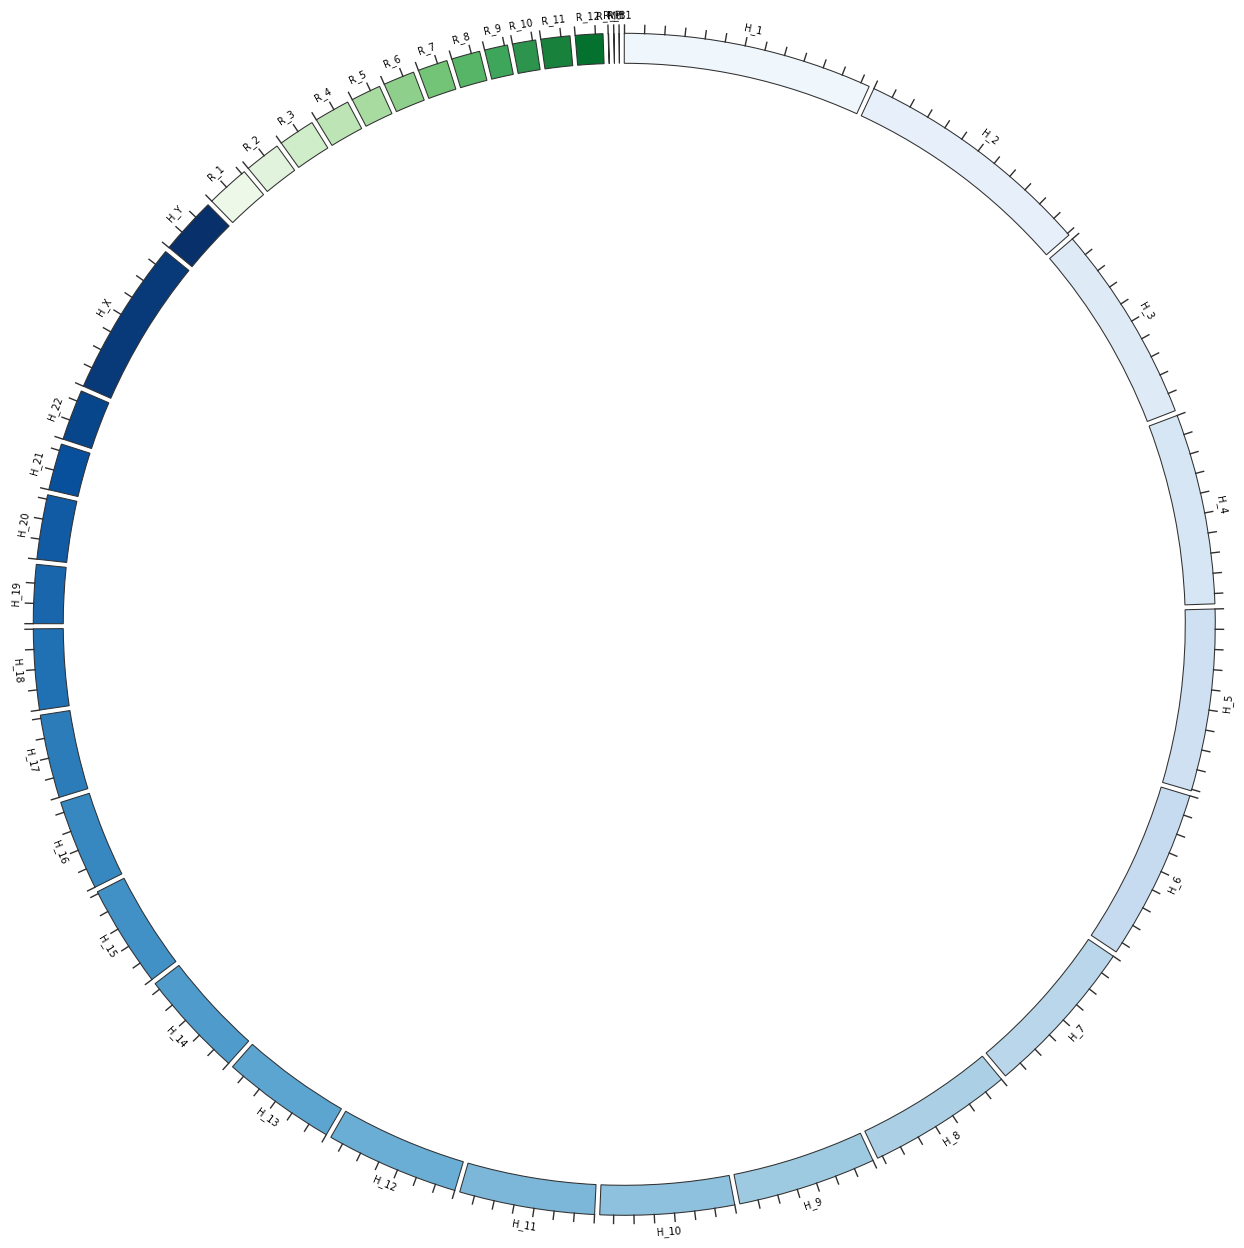

In [11]:
circle.figure

#### Scatter plot of human vs rice upregulated genes

In [12]:
#organism = "human"
df_h_score = pd.read_csv(HUMAN_POSITION, sep='\t')
df_h_score_subset = df_h_score[['Gene stable ID', # create a subset
                        'Chromosome/scaffold name', 
                        'Gene start (bp)',
                        'Gene end (bp)',
                        'HN-score(HN5)']].copy()
df_h_score_subset['Chromosome/scaffold name'] = 'H_' + df_h_score_subset['Chromosome/scaffold name'].astype(str)
df_h_score_subset['organism'] = 'human'# assign the tag


# organism = "rice"
df_r_score = pd.read_csv(RICE_POSITION, sep='\t')
df_r_score_subset = df_r_score[['Gene stable ID', # create a subset
                        'Chromosome/scaffold name', 
                        'Gene start (bp)',
                        'Gene end (bp)',
                        'HN-score(HN5)']].copy()
df_r_score_subset['Chromosome/scaffold name'] = 'R_' + df_r_score_subset['Chromosome/scaffold name'].astype(str)
df_r_score_subset['organism'] = 'rice'# assign the tag


# combined human and rice DataFrame
combined_df_score = pd.concat([df_h_score_subset, df_r_score_subset])
combined_df_score.reset_index(drop=True, inplace=True)
combined_df_score.to_csv(COMBINED_SCORE, sep='\t', index=False)

display(df_h_score_subset)
display(df_r_score_subset)
display(combined_df_score)

,Gene stable ID,Chromosome/scaffold name,Gene start (bp),Gene end (bp),HN-score(HN5),organism
0,ENSG00000173110,H_1,161524540,161526894,245,human
1,ENSG00000204389,H_6,31815543,31817946,239,human
2,ENSG00000204388,H_6,31827738,31830254,231,human
3,ENSG00000132002,H_19,14514769,14560391,210,human
4,ENSG00000151929,H_10,119651380,119677819,181,human
...,...,...,...,...,...,...
195,ENSG00000187049,H_11,61392393,61398866,51,human
196,ENSG00000176381,H_6,166305300,166308448,51,human
197,ENSG00000171931,H_17,18744026,18779349,51,human
198,ENSG00000125998,H_20,35285731,35292425,51,human


,Gene stable ID,Chromosome/scaffold name,Gene start (bp),Gene end (bp),HN-score(HN5),organism
0,Os04g0107900,R_4,483234,485978,253,rice
1,Os01g0136100,R_1,1948773,1949587,246,rice
2,Os02g0259900,R_2,9021454,9023102,238,rice
3,Os03g0245800,R_3,7697015,7698027,237,rice
4,Os03g0277300,R_3,9411494,9416082,236,rice
...,...,...,...,...,...,...
384,Os03g0820400,R_3,34427704,34428391,42,rice
385,Os10g0328600,R_10,9212944,9216458,42,rice
386,Os01g0971800,R_1,42874273,42875515,42,rice
387,Os07g0621600,R_7,25691906,25692138,42,rice


,Gene stable ID,Chromosome/scaffold name,Gene start (bp),Gene end (bp),HN-score(HN5),organism
0,ENSG00000173110,H_1,161524540,161526894,245,human
1,ENSG00000204389,H_6,31815543,31817946,239,human
2,ENSG00000204388,H_6,31827738,31830254,231,human
3,ENSG00000132002,H_19,14514769,14560391,210,human
4,ENSG00000151929,H_10,119651380,119677819,181,human
...,...,...,...,...,...,...
584,Os03g0820400,R_3,34427704,34428391,42,rice
585,Os10g0328600,R_10,9212944,9216458,42,rice
586,Os01g0971800,R_1,42874273,42875515,42,rice
587,Os07g0621600,R_7,25691906,25692138,42,rice


In [13]:
# Initialize
arcdata_dict = collections.defaultdict(dict)

for index, row in combined_df_score.iterrows():
    name = row['Chromosome/scaffold name']
    start = row['Gene start (bp)']
    end = row['Gene end (bp)']
    mid = (start + end) // 2
    value = row['HN-score(HN5)']

    if name not in arcdata_dict: # if the key is not in the dictionary, add it
        arcdata_dict[name]["positions"] = []
        arcdata_dict[name]["values"] = []

    arcdata_dict[name]["positions"].append(mid)
    arcdata_dict[name]["values"].append(value)


# plot
vmin, vmax = combined_df_score['HN-score(HN5)'].min(), combined_df_score['HN-score(HN5)'].max()
for key in arcdata_dict:
    circle.scatterplot(
        key,
        data=arcdata_dict[key]["values"],
        positions=arcdata_dict[key]["positions"], 
        rlim=[vmin-0.05*abs(vmin), vmax+0.05*abs(vmax)],
        raxis_range=(840, 940),
        facecolor="orangered",
        edgecolor="black",
        spine=True
    )

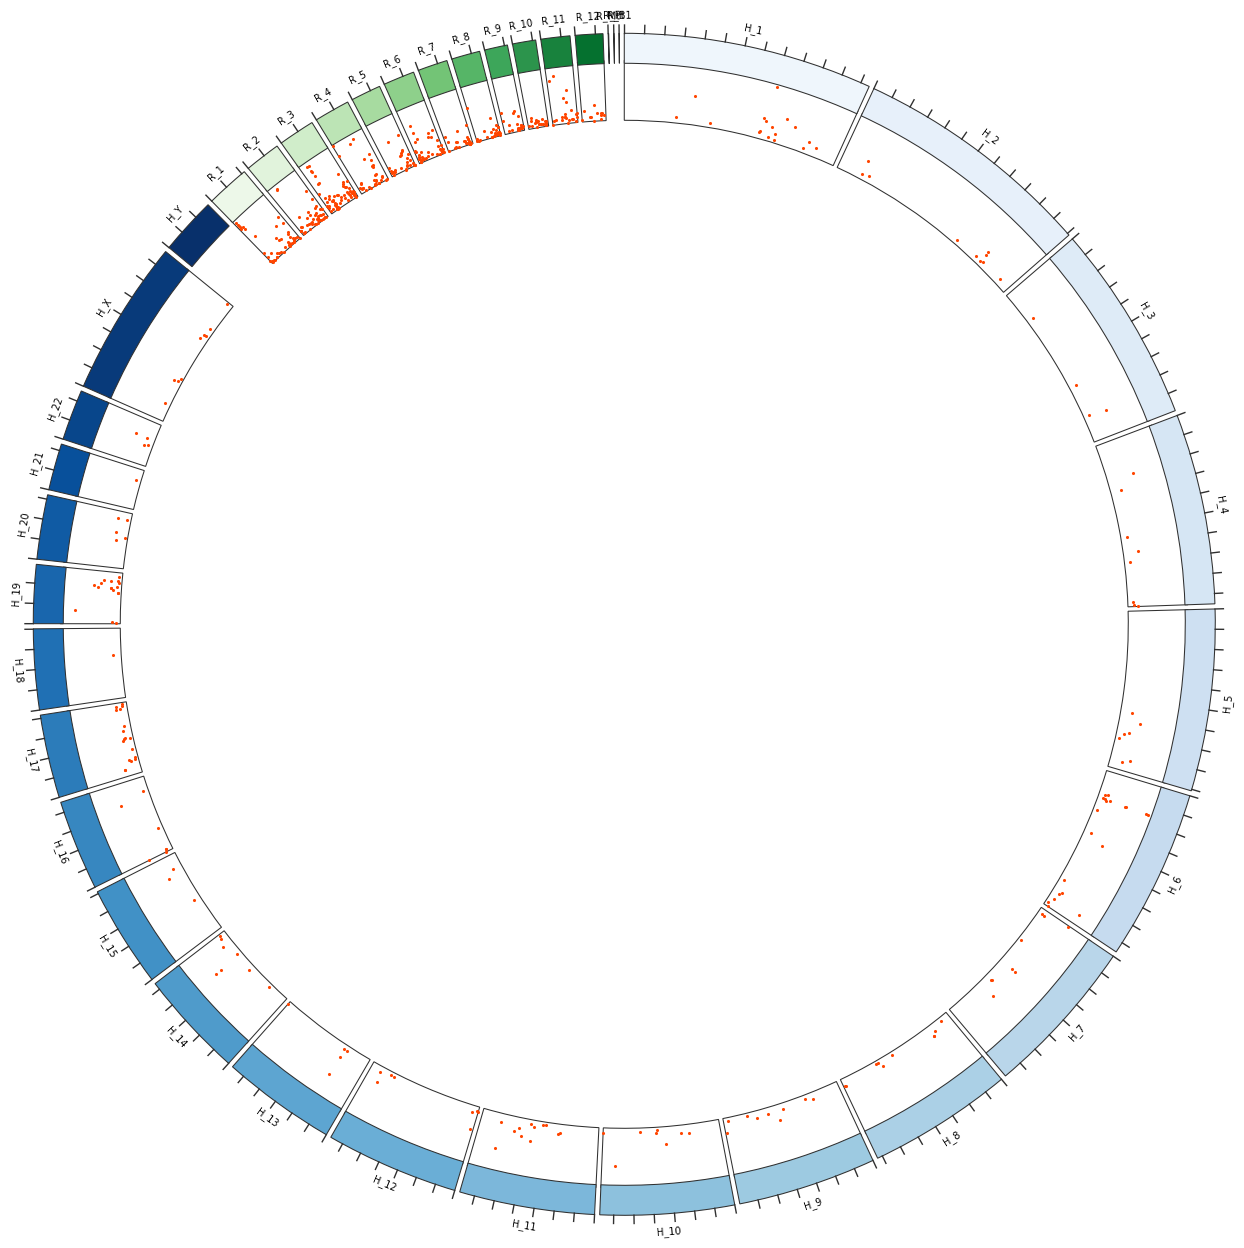

In [14]:
circle.figure

## linkplot of GOslim terms for human vs rice upregulated genes

### human

In [15]:
# Prepare the extract up genes data from GOslim file

# organism = "human"
# Using df_h_score_subset for extract up genes data from GOslim file
df_h_goslim = pd.read_csv(HUMAN_GOSLIM, sep='\t')
df_h_goslim['Chromosome/scaffold name'] = 'H_' + df_h_goslim['Chromosome/scaffold name'].astype(str)


extract_df_h_goslim = pd.merge(
    df_h_score_subset, df_h_goslim,
    left_on=['Gene stable ID', 'Chromosome/scaffold name'],
    right_on=['Gene stable ID', 'Chromosome/scaffold name'],
    how='inner'
)

extract_df_h_goslim = extract_df_h_goslim.drop_duplicates(subset=['Gene stable ID','GOSlim GOA Accession(s)', 'GOSlim GOA Description'], keep='first').copy()

# Extract genes with no annotations
extract_df_h_goslim_with_indicator = pd.merge(
    df_h_score_subset, df_h_goslim,
    left_on=['Gene stable ID', 'Chromosome/scaffold name'],
    right_on=['Gene stable ID', 'Chromosome/scaffold name'],
    how='left',
    indicator=True # add indicator column to show the difference
)

# extract_df_h_goslim_with_indicator
left_only_rows = extract_df_h_goslim_with_indicator[extract_df_h_goslim_with_indicator['_merge'] == 'left_only']

# left_only_rows
left_only_rows.to_csv(HUMAN_NO_ANNOTATION, sep='\t', index=False)
extract_df_h_goslim.to_csv(HUMAN_EXTRACT_GOSLIM_GENE, sep='\t', index=False)
display(extract_df_h_goslim)

/tmp/ipykernel_70743/2993025464.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_h_goslim = pd.read_csv(HUMAN_GOSLIM, sep='\t')


,Gene stable ID,Chromosome/scaffold name,Gene start (bp),Gene end (bp),HN-score(HN5),organism,start2 (bp),end2 (bp),GOSlim GOA Accession(s),GOSlim GOA Description
0,ENSG00000173110,H_1,161524540,161526894,245,human,161524540,161526894,GO:0140657,ATP-dependent activity
1,ENSG00000173110,H_1,161524540,161526894,245,human,161524540,161526894,GO:0044183,protein folding chaperone
2,ENSG00000173110,H_1,161524540,161526894,245,human,161524540,161526894,GO:0043226,organelle
3,ENSG00000173110,H_1,161524540,161526894,245,human,161524540,161526894,GO:0005856,cytoskeleton
4,ENSG00000173110,H_1,161524540,161526894,245,human,161524540,161526894,GO:0005815,microtubule organizing center
...,...,...,...,...,...,...,...,...,...,...
4825,ENSG00000107742,H_10,72059034,72089032,51,human,72059034,72089032,GO:0007155,cell adhesion
4826,ENSG00000107742,H_10,72059034,72089032,51,human,72059034,72089032,GO:1901135,carbohydrate derivative metabolic process
4827,ENSG00000107742,H_10,72059034,72089032,51,human,72059034,72089032,GO:0036211,protein modification process
4828,ENSG00000107742,H_10,72059034,72089032,51,human,72059034,72089032,GO:0006790,sulfur compound metabolic process


##### rice

In [16]:
# organism = "rice"
# Using df_r_score_subset for extract up genes data from GOslim file

df_r_goslim = pd.read_csv(RICE_GOSLIM, sep='\t')
df_r_goslim['Chromosome/scaffold name'] = 'R_' + df_r_goslim['Chromosome/scaffold name'].astype(str)

extract_df_r_goslim = pd.merge(
    df_r_score_subset, df_r_goslim,
    left_on=['Gene stable ID', 'Chromosome/scaffold name'],
    right_on=['Gene stable ID', 'Chromosome/scaffold name'],
    how='inner'
)

extract_df_r_goslim = extract_df_r_goslim.drop_duplicates(subset=['Gene stable ID','GOSlim GOA Accession(s)', 'GOSlim GOA Description'], keep='first').copy()

# Extract genes with no annotations
extract_df_r_goslim_with_indicator = pd.merge(
    df_r_score_subset, df_r_goslim,
    left_on=['Gene stable ID', 'Chromosome/scaffold name'],
    right_on=['Gene stable ID', 'Chromosome/scaffold name'],
    how='left',
    indicator=True # add indicator column to show the difference
)

# extract_df_r_goslim_with_indicator
left_only_rows = extract_df_r_goslim_with_indicator[extract_df_r_goslim_with_indicator['_merge'] == 'left_only']

# left_only_rows
left_only_rows.to_csv(RICE_NO_ANNOTATION, sep='\t', index=False)
extract_df_r_goslim.to_csv(RICE_EXTRACT_GOSLIM_GENE, sep='\t', index=False)
display(extract_df_r_goslim)

/tmp/ipykernel_70743/1683086555.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_r_goslim = pd.read_csv(RICE_GOSLIM, sep='\t')


,Gene stable ID,Chromosome/scaffold name,Gene start (bp),Gene end (bp),HN-score(HN5),organism,start1 (bp),end1 (bp),GOSlim GOA Accession(s),GOSlim GOA Description
0,Os04g0107900,R_4,483234,485978,253,rice,483234,485978,GO:0003674,molecular_function
1,Os04g0107900,R_4,483234,485978,253,rice,483234,485978,GO:0005515,protein binding
2,Os04g0107900,R_4,483234,485978,253,rice,483234,485978,GO:0005488,binding
3,Os04g0107900,R_4,483234,485978,253,rice,483234,485978,GO:0008150,biological_process
4,Os04g0107900,R_4,483234,485978,253,rice,483234,485978,GO:0006950,response to stress
...,...,...,...,...,...,...,...,...,...,...
2930,Os01g0971800,R_1,42874273,42875515,42,rice,42874273,42875515,GO:0008152,metabolic process
2931,Os01g0971800,R_1,42874273,42875515,42,rice,42874273,42875515,GO:0009058,biosynthetic process
2932,Os01g0971800,R_1,42874273,42875515,42,rice,42874273,42875515,GO:0006139,nucleobase-containing compound metabolic process
2933,Os01g0971800,R_1,42874273,42875515,42,rice,42874273,42875515,GO:0003700,DNA-binding transcription factor activity


## __Merge human and rice GOslim terms__

In [17]:
# merge dataframe based on common column 'GOSlim GOA Accession(s)'
merged_df_goslim = pd.merge(
    extract_df_r_goslim, 
    extract_df_h_goslim,
    left_on=['GOSlim GOA Accession(s)', 'GOSlim GOA Description'],
    right_on=['GOSlim GOA Accession(s)', 'GOSlim GOA Description'],
    how='inner',
    suffixes=('_rice', '_human')
)

# extract necessary columns

merged_df_goslim = merged_df_goslim[['GOSlim GOA Accession(s)',
                                     'GOSlim GOA Description',
                                     'Gene stable ID_rice',
                                     'Gene stable ID_human',
                                     'Chromosome/scaffold name_rice',
                                     'start1 (bp)',
                                     'end1 (bp)',
                                     'Chromosome/scaffold name_human',
                                     'start2 (bp)',
                                     'end2 (bp)',
                                     'HN-score(HN5)_rice',
                                     'HN-score(HN5)_human']]

# Remove duplicate rows based on specific columns
merged_df_goslim.drop_duplicates(inplace=True)

# for debugging purpose
unique_accessions_r = set(extract_df_r_goslim['GOSlim GOA Accession(s)'].unique())
unique_accessions_h = set(extract_df_h_goslim['GOSlim GOA Accession(s)'].unique())
common_accessions = unique_accessions_r.intersection(unique_accessions_h)
unique_accessions_merged = set(merged_df_goslim['GOSlim GOA Accession(s)'].unique())
missing_accessions = common_accessions.difference(unique_accessions_merged)
duplicates = merged_df_goslim.duplicated(subset=['GOSlim GOA Accession(s)', 'Gene stable ID_rice', 'Gene stable ID_human'], keep=False)
unique_combinations = not duplicates.any()
print(f"Number of common accessions: {len(common_accessions)}")
print(f"Number of missing accessions: {len(missing_accessions)}")
print(f"Missing accessions: {missing_accessions}")
print(f"各'Gene stable ID_rice'と'Gene stable ID_human'の組み合わせはユニークですか？: {unique_combinations}")

merged_df_goslim.to_csv(COMBINED_GOSLIM, sep='\t', index=False)
display(merged_df_goslim)

Number of common accessions: 29
Number of missing accessions: 0
Missing accessions: set()
各'Gene stable ID_rice'と'Gene stable ID_human'の組み合わせはユニークですか？: True


,GOSlim GOA Accession(s),GOSlim GOA Description,Gene stable ID_rice,Gene stable ID_human,Chromosome/scaffold name_rice,start1 (bp),end1 (bp),Chromosome/scaffold name_human,start2 (bp),end2 (bp),HN-score(HN5)_rice,HN-score(HN5)_human
0,GO:0005886,plasma membrane,Os04g0107900,ENSG00000109846,R_4,483234,485978,H_11,111908564,111923722,253,173
1,GO:0005886,plasma membrane,Os04g0107900,ENSG00000166592,R_4,483234,485978,H_16,66921685,66925535,253,155
2,GO:0005886,plasma membrane,Os04g0107900,ENSG00000226979,R_4,483234,485978,H_6,31572054,31574324,253,154
3,GO:0005886,plasma membrane,Os04g0107900,ENSG00000162616,R_4,483234,485978,H_1,77979175,78017964,253,149
4,GO:0005886,plasma membrane,Os04g0107900,ENSG00000116741,R_4,483234,485978,H_1,192809039,192812275,253,122
...,...,...,...,...,...,...,...,...,...,...,...,...
15167,GO:0005856,cytoskeleton,Os01g0257300,ENSG00000139908,R_1,8586157,8586941,H_14,24205696,24208362,45,55
15168,GO:0005856,cytoskeleton,Os01g0257300,ENSG00000149781,R_1,8586157,8586941,H_11,64205926,64223896,45,53
15169,GO:0005856,cytoskeleton,Os01g0257300,ENSG00000174226,R_1,8586157,8586941,H_8,100572889,100663415,45,51
15170,GO:0005856,cytoskeleton,Os01g0257300,ENSG00000187049,R_1,8586157,8586941,H_11,61392393,61398866,45,51


In [18]:
#Count the occurrences of each 'GOSlim GOA Accession(s)'
accession_counter = Counter(merged_df_goslim['GOSlim GOA Accession(s)'])

#Sort the DataFrame based on the counts
merged_df_goslim['count'] = merged_df_goslim['GOSlim GOA Accession(s)'].map(accession_counter)
merged_df_goslim_sorted = merged_df_goslim.sort_values('count', ascending=False).drop('count', axis=1)

merged_df_goslim_sorted.to_csv(COMBINED_GOSLIM_SORTED, sep='\t', index=False)
display(merged_df_goslim_sorted)


,GOSlim GOA Accession(s),GOSlim GOA Description,Gene stable ID_rice,Gene stable ID_human,Chromosome/scaffold name_rice,start1 (bp),end1 (bp),Chromosome/scaffold name_human,start2 (bp),end2 (bp),HN-score(HN5)_rice,HN-score(HN5)_human
5332,GO:0003824,catalytic activity,Os12g0106000,ENSG00000178297,R_12,320568,323716,H_19,2360238,2426261,47,72
4036,GO:0003824,catalytic activity,Os02g0630300,ENSG00000144381,R_2,25199505,25203742,H_2,197486584,197516737,58,55
4045,GO:0003824,catalytic activity,Os05g0200500,ENSG00000188536,R_5,6273311,6282541,H_16,172876,173710,57,139
4044,GO:0003824,catalytic activity,Os05g0200500,ENSG00000204390,R_5,6273311,6282541,H_6,31809619,31815283,57,150
4043,GO:0003824,catalytic activity,Os05g0200500,ENSG00000166592,R_5,6273311,6282541,H_16,66921685,66925535,57,155
...,...,...,...,...,...,...,...,...,...,...,...,...
14050,GO:0005198,structural molecule activity,Os01g0105800,ENSG00000112110,R_1,306871,308842,H_6,159789812,159798436,53,63
13632,GO:0005777,peroxisome,Os06g0253100,ENSG00000165507,R_6,7940956,7941680,H_10,44970981,44978809,129,70
13633,GO:0005777,peroxisome,Os07g0529000,ENSG00000165507,R_7,20691213,20693521,H_10,44970981,44978809,59,70
15021,GO:0005840,ribosome,Os11g0303800,ENSG00000112110,R_11,11436951,11446262,H_6,159789812,159798436,65,63


In [19]:
# Add color data to 'GOSlim GOA Description' column
unique_ontologies = merged_df_goslim_sorted['GOSlim GOA Description'].unique()

n = len(unique_ontologies)
colors = cm.rainbow(np.linspace(0, 1, n)) # create n colors by cm.rainbow

# create ontology_color_dict
ontology_color_dict = {term: color for term, color in zip(unique_ontologies, colors)}

# add to garc_dict
for term, color in ontology_color_dict.items():
    circle._garc_dict[term] = {'facecolor': color, 'edgecolor': color}

In [20]:
values_all   = [] 
arcdata_dict = collections.defaultdict(dict)

# Count the number of ontology terms
ontology_count = Counter()
with open(COMBINED_GOSLIM_SORTED, mode='r', newline='') as f:
    reader = csv.DictReader(f, delimiter='\t')
    for row in reader:
        ontology = row['GOSlim GOA Description']
        ontology_count[ontology] += 1

min_linewidth = 1 * 10**-40
max_linewidth = 0.002

min_count = min(ontology_count.values())
max_count = max(ontology_count.values())


with open(COMBINED_GOSLIM_SORTED, mode='r', newline='') as f:
    reader = csv.DictReader(f, delimiter='\t')
    for row in reader:
        name1 = row['Chromosome/scaffold name_rice'] # rice
        start1 = int(row['start1 (bp)'])
        end1 = int(row['end1 (bp)'])
        name2 = row['Chromosome/scaffold name_human'] # human
        start2 = int(row['start2 (bp)'])
        end2 = int(row['end2 (bp)'])
        ontology = row['GOSlim GOA Description']

        # For debugging
        #print("Debugging Info:")
        #print(f"ontology: {ontology}")
        #print(f"circle._garc_dict[ontology]: {circle._garc_dict.get(ontology, 'Not found')}")

        count = ontology_count[ontology]
        linewidth = min_linewidth + (max_linewidth - min_linewidth) * ((count - min_count) / (max_count - min_count))
        
        source = (name1, start1, end1, 840)
        destination = (name2, start2, end2, 840)
        circle.chord_plot(source, 
                          destination, 
                          facecolor=circle._garc_dict[ontology]['facecolor'],
                          linewidth=linewidth,
                          edgecolor=circle._garc_dict[ontology]['edgecolor']
                          )

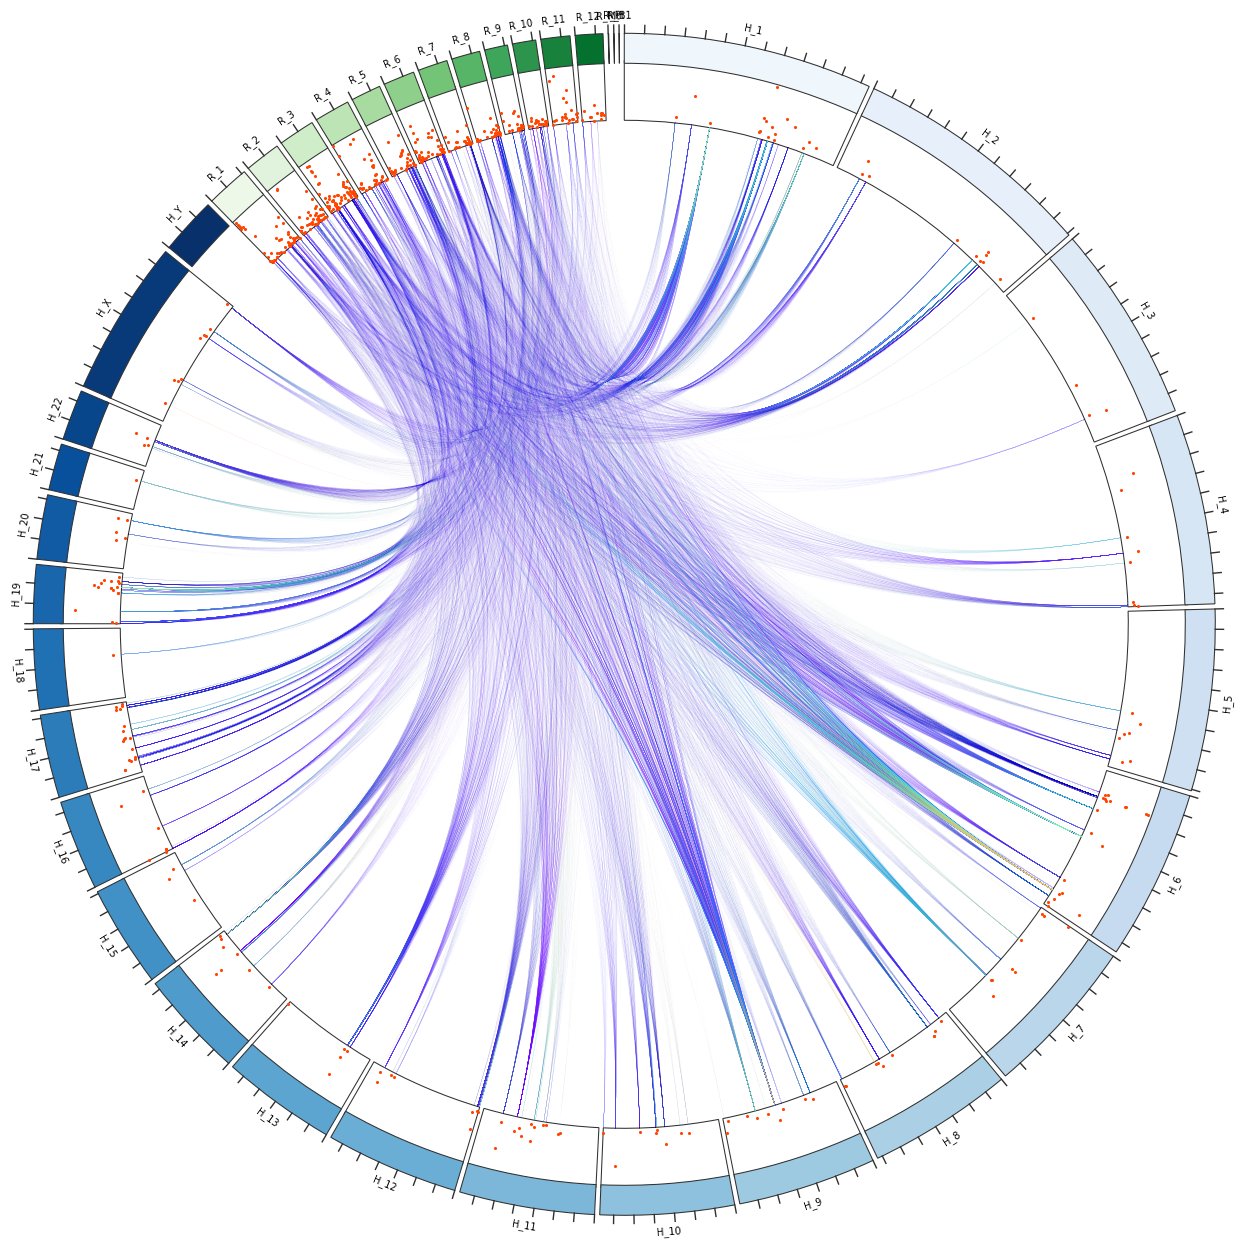

In [21]:
circle.figure

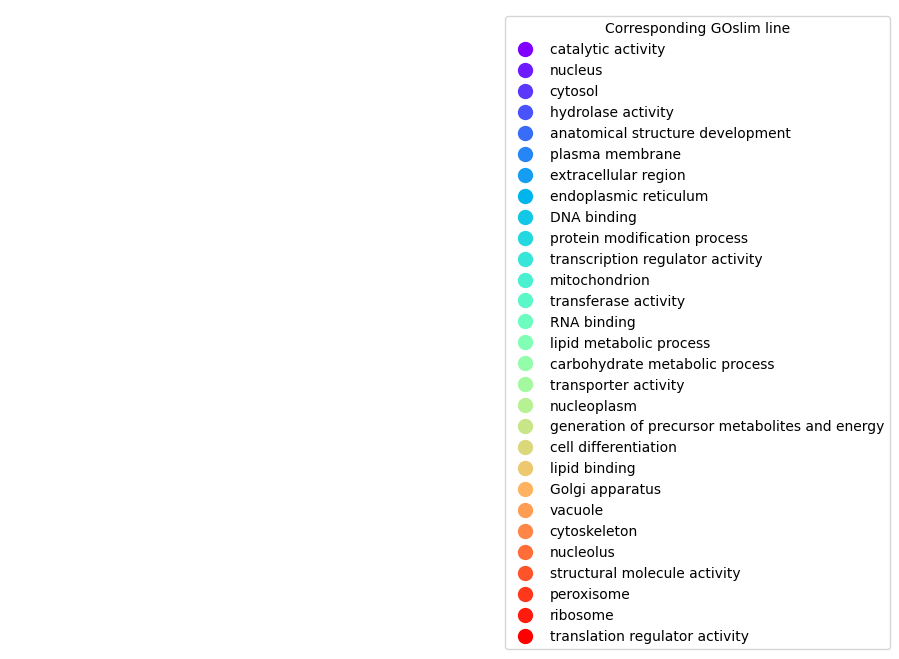

In [22]:
# add legend as a independent figure
fig, ax = plt.subplots(figsize=(6, 6))
for ontology, color in ontology_color_dict.items():
    ax.plot([], [], 
            label=ontology, 
            color=color, 
            marker='o', 
            markersize=10, 
            linestyle='None')

ax.legend(title="Corresponding GOslim line", 
          bbox_to_anchor=(1.05, 1), 
          loc='upper left')
ax.axis('off')
plt.show()
